In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from my_dataset import *
from ultralytics import YOLO
import cv2
%load_ext autoreload
%autoreload 2

In [13]:
train_mura = pd.read_csv('../MURA-v1.1/train_image_paths.csv', header=None, names=['paths'])
test_mura = pd.read_csv('../MURA-v1.1/valid_image_paths.csv',header=None, names=['paths'])
train_mura_labels = pd.read_csv('../MURA-v1.1/train_labeled_studies.csv',header=None, names=['labels'])
test_mura_labels = pd.read_csv('../MURA-v1.1/valid_labeled_studies.csv',header=None, names=['labels'])
train_mura['indices'] = train_mura.paths.str[:-10]
test_mura['indices'] = test_mura.paths.str[:-10]
# full MURA with all parts
# can select parts by filtering indices
train_data = pd.merge(train_mura, train_mura_labels, left_on='indices', right_index=True)
test_data = pd.merge(test_mura, test_mura_labels, left_on='indices', right_index=True)

In [14]:
# construct base dataset: hand and finger only
# hand_finger = train_data[train_data['indices'].str.contains('HAND') | train_data['indices'].str.contains('FINGER')].reset_index()
# hand_finger_test = test_data[test_data['indices'].str.contains('HAND') | test_data['indices'].str.contains('FINGER')].reset_index()
se = train_data[train_data['indices'].str.contains('SHOULDER') | train_data['indices'].str.contains('SHOULDER')].reset_index()
se_test = test_data[test_data['indices'].str.contains('ELBOW') | test_data['indices'].str.contains('ELBOW')].reset_index()


In [15]:
resize = 256
trans = transforms.Compose([transforms.Resize((resize, resize)),
                            transforms.Lambda(lambda img: img.convert('RGB')),
                            transforms.ToTensor()])
classes = {'shoulder':0, 'elbow':1}
# classes = {'hand':0, 'finger':1}
# base_dataset = ImageSet(hand_finger.paths, hand_finger.labels, trans, classes, root_adj='../')
# base_testset = ImageSet(hand_finger_test.paths, hand_finger_test.labels, trans, classes, root_adj='../')
base_dataset = ImageSet(se.paths, se.labels, trans, classes, root_adj='../')
base_testset = ImageSet(se_test.paths, se_test.labels, trans, classes, root_adj='../')

In [16]:
batch_size = 1
base_trainloader = DataLoader(base_dataset, batch_size=batch_size, shuffle=True)
base_testloader = DataLoader(base_testset, batch_size=batch_size, shuffle=True)

In [ ]:
for idx, x in enumerate(base_testloader):
    image, label = x
    image = image.detach().numpy()[0].transpose(1,2,0)
    # image = image.astype(np.uint8)
    image = (image * 255).astype(np.uint8)
    if label[0][1] == 0.5:
        label = label.detach().numpy().astype(str).tolist()[0]
        with open(f'../shoulder_elbow_datasets/labels/val/image{idx+1}.txt', 'w') as f:
            label = ' '.join(label)
            f.write(label)
    cv2.imwrite(f'../shoulder_elbow_datasets/images/val/image{idx+1}.jpg', image)




In [9]:
image.shape

(256, 256, 3)

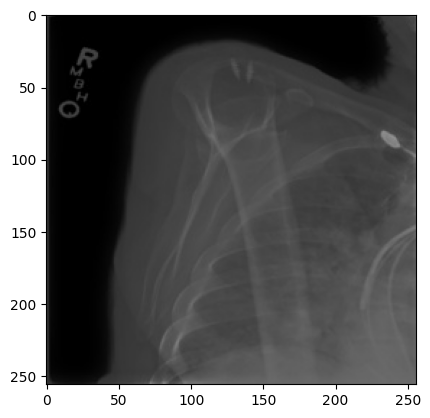

In [21]:
plt.imshow(cv2.imread('../shoulder_elbow_datasets/images/train/image1.jpg'))

In [7]:
# model = YOLO('yolov8n.pt') # pretrained
model = YOLO('yolov8n.yaml') # not pretrained?

In [8]:
model.train(data='train.yaml', epochs=1)

Ultralytics 8.3.39  Python-3.12.1 torch-2.2.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=train.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning C:\duke_assignments\hand_finger_datasets\labels\train... 10649 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10649/10649 [00:07<00:00, 1477.76it/s]


train: New cache created: C:\duke_assignments\hand_finger_datasets\labels\train.cache


val: Scanning C:\duke_assignments\hand_finger_datasets\labels\val... 921 images, 0 backgrounds, 0 corrupt: 100%|██████████| 921/921 [00:01<00:00, 820.97it/s]


val: New cache created: C:\duke_assignments\hand_finger_datasets\labels\val.cache
Plotting labels to runs\detect\train10\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train10
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.11G      3.071      4.819      4.149         14        640:  16%|█▌        | 104/666 [00:27<02:27,  3.81it/s]


KeyboardInterrupt: 